<a href="https://colab.research.google.com/github/arka57/Potato-Disease-Classification/blob/main/Potato_Disease_Classification_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import torchvision
import torchvision.models as models

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
cd MyDrive

/gdrive/MyDrive


In [4]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
full_data = tv.datasets.ImageFolder(root="Potato_Disease_Classification",transform=transform)

In [ ]:
image,label=full_data[0]

In [ ]:
image=image.detach().numpy()
image=np.transpose(image,(1,2,0))
#plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [6]:
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size
val_size=int(0.5*test_size)
test_size=test_size-val_size

In [7]:
train_data, test_data,validation_data = random_split(full_data, [train_size, test_size,val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
#Defining The Model

In [30]:
vgg=models.vgg16(weights='IMAGENET1K_V1')

In [31]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
print(vgg.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [13]:
print(vgg.avgpool)

AdaptiveAvgPool2d(output_size=(7, 7))


In [14]:
print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
#Will use pre-Traind VGG model. So setting the parameters should not be trained further

In [16]:
for i in vgg.parameters():
    
    i.requires_grad=False
    

In [ ]:
#Will now modify the model to classify only 3 classes

In [33]:
for i,j in enumerate(vgg.parameters()):
    if(i>20):
        j.requires_grad=True
    else:
        j.requires_grad=False    

In [34]:
out_features=3
last_in_features=vgg.classifier[6].in_features

In [35]:
vgg.classifier[6]=nn.Linear(last_in_features,out_features)

In [36]:
for i in vgg.parameters():
    if(i.requires_grad!=False):
        print(i.shape)

torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([3, 4096])
torch.Size([3])


In [ ]:
#So now only the last layers require training

In [37]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.01)

In [40]:
def evaluation(dataloader):
    total=0
    correct=0
    for data in dataloader:
        input,label=data
        input,label = input.to(device), label.to(device)
        output=vgg.forward(input)
        _,pred=torch.max(output,1)
        total+=label.size(0)
        correct+=(pred==label).sum().item()
    return (correct/total)*100    

Epoch 0/50 ,Training accuracy 92.68,Validation Accuracy 89.35
Epoch 1/50 ,Training accuracy 90.18,Validation Accuracy 89.35
Epoch 2/50 ,Training accuracy 95.58,Validation Accuracy 95.37
Epoch 3/50 ,Training accuracy 96.11,Validation Accuracy 93.98
Epoch 4/50 ,Training accuracy 96.75,Validation Accuracy 97.22
Epoch 5/50 ,Training accuracy 96.75,Validation Accuracy 97.69
Epoch 6/50 ,Training accuracy 97.39,Validation Accuracy 97.69
Epoch 7/50 ,Training accuracy 97.68,Validation Accuracy 94.91
Epoch 8/50 ,Training accuracy 97.56,Validation Accuracy 97.69
Epoch 9/50 ,Training accuracy 97.85,Validation Accuracy 98.15
Epoch 10/50 ,Training accuracy 98.20,Validation Accuracy 99.07
Epoch 11/50 ,Training accuracy 97.04,Validation Accuracy 96.76
Epoch 12/50 ,Training accuracy 98.08,Validation Accuracy 95.83
Epoch 13/50 ,Training accuracy 98.37,Validation Accuracy 97.69
Epoch 14/50 ,Training accuracy 97.79,Validation Accuracy 98.61
Epoch 15/50 ,Training accuracy 98.43,Validation Accuracy 97.69
Ep

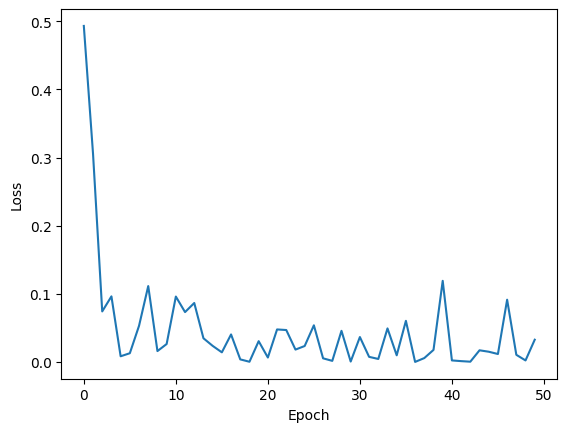

CPU times: user 25min 34s, sys: 1min, total: 26min 34s
Wall time: 29min 15s


In [41]:
%%time
epoch=50
min_loss=1000
loss_epoch=[]
train_accuracy_epoch=[]
validation_accuracy_epoch=[]
for i in range(0,epoch):
    for j,data in enumerate(train_loader,0):
        input,label=data
        input,label = input.to(device), label.to(device)
        
        output=vgg.forward(input)
        
        loss=loss_fn(output,label)
        loss.backward()
        opt.step()
        opt.zero_grad()

        del input, label, output
        torch.cuda.empty_cache()

        if(loss<min_loss):
            min_loss=loss
            best_model=copy.deepcopy(vgg.state_dict())

    loss_epoch.append(loss.item())
    x=evaluation(train_loader)
    y=evaluation(validation_loader)
    print('Epoch %d/%d ,Training accuracy %0.2f,Validation Accuracy %0.2f' %(i,epoch,x,y))
    train_accuracy_epoch.append(x)
    validation_accuracy_epoch.append(y)
plt.plot(loss_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()  

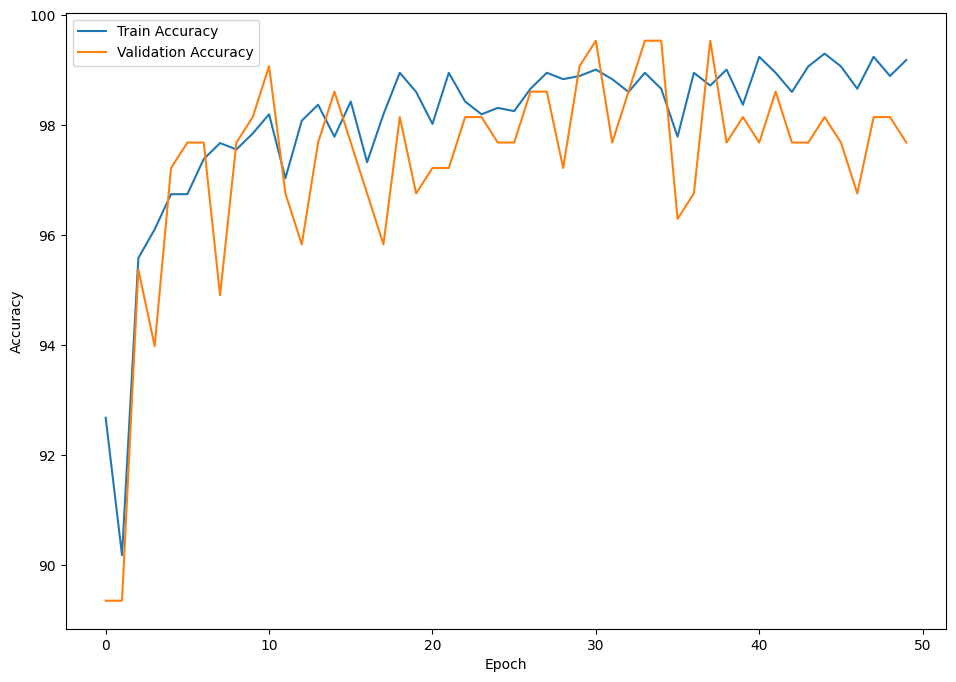

In [44]:
plt.figure(figsize=(25, 8))
plt.subplot(1,2,1)
plt.plot(train_accuracy_epoch,label="Train Accuracy")
plt.plot(validation_accuracy_epoch,label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
#plt.ylim(0,100)
plt.legend()
plt.show()

In [45]:
torch.save(best_model,"potato_vgg3.th")